# Autoencoder Convolucional

Ainda com o dataset MNIST, iremos melhorar nossa performance utilizando camadas convolucionais. Não se preocupe, o objetivo aqui é apenas mostrar seu funcionamento em alto nível, não será exigido um alto grau de conhecimento sobre CNNs, pois esse não é o foco neste momento.

- A parte do codificador será composta por uma camadas convolucionais e de pooling.
- O decodificador será formado por **camadas convolucionais transpostas**, que irão realizar upsampling da representação comprimida.

<img src='notebook_ims/autoencoder_1.png' />

### Representação Comprimida

De forma geral, a representação comprimida possui informações chave sobre a imagem original e pode ser utilizada também para a remoção de ruídos das imagens ou realizar outros tipos de reconstrução ou transformações.

<img src='notebook_ims/denoising.png' width=60%/>

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [2]:
# Create training and test dataloaders

num_workers = 1
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualização dos Dados

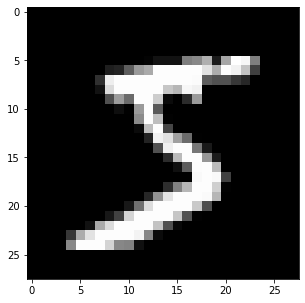

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Autoencoder Convolucional

#### Codificador
A parte do codificador da rede será uma pirâmide convolucional típica. Cada camada convolucional será seguida por uma camada de max-pooling para reduzir as dimensões das camadas.

>O max-pooling é uma camada que realiza subamostragem. No nosso caso, cada vez que uma informação é passada por uma camada de max-pooling, as dimensões da informação são reduzidas na metade.

#### Decodificador
O decodificador precisa converter uma representação estreita e compacta em uma imagem ampla e reconstruída. Por exemplo, a representação pode ser uma camada max-pool de 7x7x4. Esta é a saída do codificador, mas também é a entrada para o decodificador. Queremos obter uma imagem de 28x28x1 do decodificador e, portanto, precisamos partir da representação comprimida para voltar à imagem original. Um esquema da rede é mostrado abaixo.

<img src='notebook_ims/conv_enc_1.png' width=640px>


Aqui, a nossa camada final do codificador possui o tamanho 7x7x4 = 196. As imagens originais têm tamanho 28x28 = 784, portanto, o vetor codificado é 25% do tamanho da imagem original. Estes são apenas os tamanhos sugeridos para cada uma das camadas. Sinta-se à vontade para alterar as profundidades e os tamanhos. Na verdade, é recomendável adicionar camadas adicionais para tornar essa representação ainda menor! Lembre-se de que nosso objetivo aqui é encontrar uma representação menor dos dados de entrada.

### Convoluções de transposição, decodificador

Este decodificador usa camadas convolucionais transpostas para aumentar a largura e a altura das camadas de entrada. Eles funcionam quase exatamente da mesma forma que as camadas convolucionais, mas ao contrário. Um passo na camada de entrada resulta em um passo (stride) maior na camada de convolução transposta. Por exemplo, se você tiver um kernel 3x3, um patch 3x3 na camada de entrada será reduzido para uma unidade em uma camada convolucional. Comparativamente, uma unidade na camada de entrada será expandida para um path 3x3 em uma camada de convolução transposta. O PyTorch nos fornece uma maneira fácil de criar as camadas, [`nn.ConvTranspose2d`] (https://pytorch.org/docs/stable/nn.html#convtranspose2d).

É importante observar que as camadas de convolução de transposição podem levar a artefatos nas imagens finais, como padrões de tabuleiro de damas. Isso ocorre devido à sobreposição nos kernels, o que pode ser evitado definindo o tamanho da passada (stride) e do kernel iguais. [Este artigo Distill] (http://distill.pub/2016/deconv-checkerboard/) de Augustus Odena, *et al*, os autores mostram que esses artefatos de tabuleiro de damas podem ser evitados redimensionando as camadas usando o vizinho mais próximo ou interpolação bilinear (upsampling) seguida por uma camada convolucional.

> Ao construir o decodificador, lembre-se de que as camadas convolucionais de transposição podem aumentar a amostra de uma entrada por um fator de 2 usando um stride e um kernel_size de 2.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


---
## Treinamento

Não estou muito interessado em validação aqui, então monitorarei a perda de treinamento e a perda de teste posteriormente.

Não estamos preocupados com labels neste caso, apenas imagens, que podemos obter do `train_loader`. Como estamos comparando valores de pixel em imagens de entrada e saída, será melhor usar uma função de loss destinada a uma tarefa de regressão. Regressão está relacionada com a comparação de quantidades, não com valores probabilísticos. Portanto, neste caso, usaremos o `MSELoss`. Compare as imagens de saída com as imagens de entrada da seguinte maneira:

```
loss = criterion(outputs, images)
```

Como esse é um autoencoder convencional, nossas imagens _não_ precisam ser achatadas antes de serem passadas como entrada para o nosso modelo.

In [8]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.604463
Epoch: 2 	Training Loss: 0.372801
Epoch: 3 	Training Loss: 0.329714
Epoch: 4 	Training Loss: 0.282565
Epoch: 5 	Training Loss: 0.242547
Epoch: 6 	Training Loss: 0.230748
Epoch: 7 	Training Loss: 0.222918
Epoch: 8 	Training Loss: 0.217509
Epoch: 9 	Training Loss: 0.213246
Epoch: 10 	Training Loss: 0.209967
Epoch: 11 	Training Loss: 0.207725
Epoch: 12 	Training Loss: 0.206106
Epoch: 13 	Training Loss: 0.204837
Epoch: 14 	Training Loss: 0.203778
Epoch: 15 	Training Loss: 0.202877
Epoch: 16 	Training Loss: 0.202088
Epoch: 17 	Training Loss: 0.201384
Epoch: 18 	Training Loss: 0.200747
Epoch: 19 	Training Loss: 0.200153
Epoch: 20 	Training Loss: 0.199587


## Checando os Resultados

Abaixo, plotamos algumas das imagens do conjunto de teste junto com suas reconstruções. Elas parecem um pouco grosseiras nas bordas, provavelmente devido ao efeito quadriculado que mencionamos acima que costuma acontecer com as camadas de transposição.

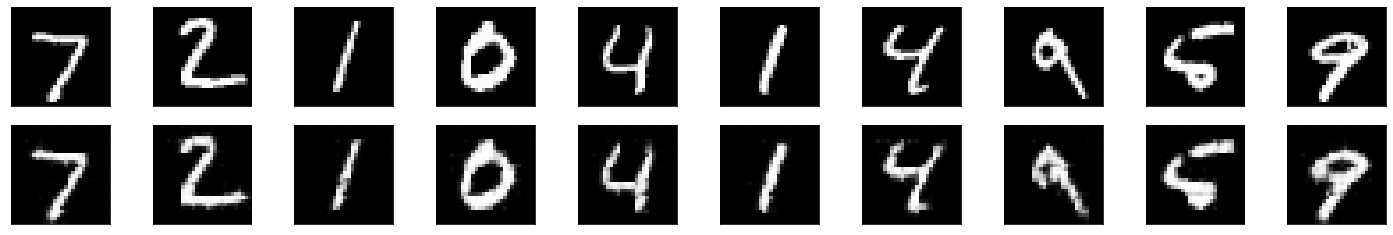

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)